In [1]:
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy import units as u
import glob
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np
import pdb
# import desi

[0.05257646 1.74439053] [[ 1.13647074e-05 -5.78997948e-05]
 [-5.78997948e-05  3.31964284e-04]]
[0.05810691 1.67501338] [[ 2.71049921e-06 -1.29506813e-05]
 [-1.29506813e-05  6.84556635e-05]]
[0.05131122 1.66541422] [[ 3.83567519e-06 -1.98499896e-05]
 [-1.98499896e-05  1.08805250e-04]]
[0.03754064 1.72739524] [[ 1.76410898e-06 -1.40381678e-05]
 [-1.40381678e-05  1.22239578e-04]]
[0.03872865 1.7476325 ] [[ 1.09949950e-05 -7.49240186e-05]
 [-7.49240186e-05  5.63418233e-04]]


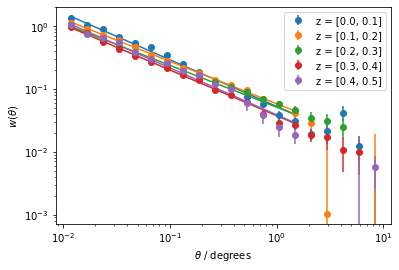

In [16]:
reload(desi)
desi.w_plot(prefix='/pscratch/sd/l/loveday/DESI/w_N/', fit_range=[0.01, 2])

In [19]:
def legacy_desi(maglim=23, rlim=5.0*u.deg, r_radius=2.0*u.deg,
                ranfile='randoms-south-1-0.fits',
                galout='/pscratch/sd/l/loveday/Legacy/legacy_desi.fits',
                ranout='/pscratch/sd/l/loveday/Legacy/legacy_desi_ran.fits'):
    """Compile Legacy DR10 data within the 20 DESI EDR rosettes."""

    # Rosette centres
    rcen = np.array([[150.10, 2.182], [179.60, 0.000], [183.10, 0.000],
            [189.90, 61.800], [194.75, 28.200], [210.00, 5.000], 
            [215.50, 52.500], [217.80, 34.400], [216.30, -0.600], 
            [219.80, -0.600], [218.05, 2.430], [242.75, 54.980],
            [241.05, 43.450], [245.88, 43.450], [252.50, 34.500],
            [269.73, 66.020], [194.75, 24.700], [212.80, -0.600],
            [269.73, 62.520], [236.10, 43.450]])
    rcoords = SkyCoord(rcen[:, 0], rcen[:, 1], frame='icrs', unit='deg')

    # Sweep centres
    path = '/global/cfs/cdirs/cosmo/data/legacysurvey/dr10/south/sweep/10.0/'
    sweeps = np.array(glob.glob(path + 'sweep*.fits'))
    ras, decs = [], []
    for sweep in sweeps:
        # Check if sweep centre lies within rlim of a rosette centre
        ralo = int(sweep[-20:-17])
        declo = int(sweep[-16:-13])
        sign = sweep[-17]
        if sign == 'm':
            declo = -declo
        rahi = int(sweep[-12:-9])
        dechi = int(sweep[-8:-5])
        sign = sweep[-9]
        if sign == 'm':
            dechi = -dechi
        ras.append(0.5*(ralo + rahi))
        decs.append(0.5*(declo + dechi))
    scoords = SkyCoord(ras, decs, frame='icrs', unit='deg')

    # Find sweeps that lie within distance rlim of a rosette
    idxr, idxs, d2d, d3d = scoords.search_around_sky(rcoords, rlim)
    sweeps = sweeps[np.unique(idxs)]
    print('Using sweeps: ', np.unique(idxs), sweeps)
        
    # Extract Legacy galaxies with mag_z < maglim that lie within r_radius of a rosette
    # NB Rosette id corresponds to first rosette a source is associated with, not the closest
    ra, dec, mag, rosette = np.array(()), np.array(()), np.array(()), np.array((), dtype=np.int32)
    for sweep in sweeps:
        t = Table.read(sweep)
        gal = (t['TYPE'] != 'PSF') * (t['TYPE'] != 'DUP')
        t = t[gal]
        flux_z = t['FLUX_Z']/t['MW_TRANSMISSION_Z']
        good = (flux_z > 0) * (flux_z < 1e6)
        t = t[good]
        mag_z = 22.5 - 2.5*np.log10(flux_z[good])
        sel = mag_z < maglim
        t = t[sel]
        mag_z = mag_z[sel]
        gcoords = SkyCoord(t['RA'], t['DEC'], frame='icrs', unit='deg')
        idxr, idxg, d2d, d3d = gcoords.search_around_sky(rcoords, r_radius)
        idxg, ridx = np.unique(idxg, return_index=True)
        ra = np.hstack((ra, t['RA'][idxg]))
        dec = np.hstack((dec, t['DEC'][idxg]))
        mag = np.hstack((mag, mag_z[idxg]))
        rosette = np.hstack((rosette, idxr[ridx]))
        print(sweep, len(mag_z[idxg]))
        
    # Write out the selected galaxies
    t = Table((ra, dec, mag, rosette), names=('RA', 'DEC', 'Z_MAG', 'ROSETTE'))
    t.write(galout, overwrite=True)
    print(len(ra), 'total galaxies')
    
    # Now the randoms
    ra, dec, rosette = np.array(()), np.array(()), np.array((), dtype=np.int32)
    path = '/global/cfs/cdirs/cosmo/data/legacysurvey/dr10/south/randoms/'
    t = Table.read(path + ranfile)
    gcoords = SkyCoord(t['RA'], t['DEC'], frame='icrs', unit='deg')
    idxr, idxg, d2d, d3d = gcoords.search_around_sky(rcoords, r_radius)
    idxg, ridx = np.unique(idxg, return_index=True)
    ra = np.hstack((ra, t['RA'][idxg]))
    dec = np.hstack((dec, t['DEC'][idxg]))
    rosette = np.hstack((rosette, idxr[ridx]))
    t = Table((ra, dec, rosette), names=('RA', 'DEC', 'ROSETTE'))
    t.write(ranout, overwrite=True)
    print(len(ra), 'total randoms')


In [15]:
c1 = SkyCoord([0, 0.5, 1], [2, 2.5, 3], frame='icrs', unit='deg')
c2 = SkyCoord([4, 5], [6, 7], frame='icrs', unit='deg')
idx2, idx1, d2d, d3d = c1.search_around_sky(c2, 6.0*u.deg)
print(idx1, idx2, d2d, d3d)
print(len(idx1), len(idx2), len(d2d), len(d3d))
unique, ridx, counts = np.unique(idx1, return_index=True, return_counts=1)
print(unique, idx2[ridx])

[0 1 2 2] [0 0 0 1] [5d38m57.78578616s 4d56m33.19791725s 4d14m09.09316443s 5d38m43.84603596s] [0.09856043 0.08623711 0.07391285 0.09849293]
4 4 4 4
[0 1 2] [0 0 0]


In [20]:
legacy_desi()

Using sweeps:  [   6   15   46   49   59   60  104  165  166  238  344  361  557  620
  664  756  795  857  957  973 1006 1018 1043 1120 1132 1156 1165 1322
 1330 1365] ['/global/cfs/cdirs/cosmo/data/legacysurvey/dr10/south/sweep/10.0/sweep-190p025-195p030.fits'
 '/global/cfs/cdirs/cosmo/data/legacysurvey/dr10/south/sweep/10.0/sweep-215p000-220p005.fits'
 '/global/cfs/cdirs/cosmo/data/legacysurvey/dr10/south/sweep/10.0/sweep-210p000-215p005.fits'
 '/global/cfs/cdirs/cosmo/data/legacysurvey/dr10/south/sweep/10.0/sweep-150p000-155p005.fits'
 '/global/cfs/cdirs/cosmo/data/legacysurvey/dr10/south/sweep/10.0/sweep-175m005-180p000.fits'
 '/global/cfs/cdirs/cosmo/data/legacysurvey/dr10/south/sweep/10.0/sweep-210p030-215p035.fits'
 '/global/cfs/cdirs/cosmo/data/legacysurvey/dr10/south/sweep/10.0/sweep-205p000-210p005.fits'
 '/global/cfs/cdirs/cosmo/data/legacysurvey/dr10/south/sweep/10.0/sweep-180p000-185p005.fits'
 '/global/cfs/cdirs/cosmo/data/legacysurvey/dr10/south/sweep/10.0/sweep-195p020

## Plot sky distribution of DESI and Legacy galaxies

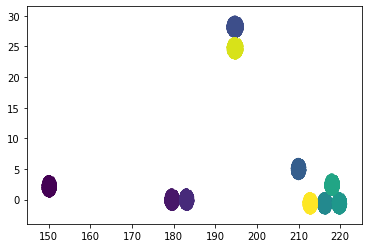

In [37]:
path = '/global/cfs/cdirs/desi/public/edr/vac/edr/lss/v2.0/LSScats/clustering/'
# t = Table.read('/pscratch/sd/l/loveday/Legacy/legacy_desi.fits')
# plt.scatter(t['RA'], t['DEC'], s=0.1, c='k')
t = Table.read(path + 'BGS_ANY_S_clustering.dat.fits')
plt.scatter(t['RA'], t['DEC'], s=0.1, c=t['ROSETTE_NUMBER'])
# plt.xlim(240, 260)
# plt.ylim(32, 36)
plt.show()


In [26]:
pdb.pm()

> /tmp/ipykernel_870224/1070764748.py(39)legacy_desi()
     37     # Find sweeps that lie within distance rlim of a rosette
     38     idxr, idxs, d2d, d3d = scoords.search_around_sky(rcoords, rlim)
---> 39     sweeps = sweeps[idxs]
     40     print('Using sweeps: ', sweeps)
     41 



ipdb>  idxs


array([  49,  620,   59,  165, 1132, 1156,  165, 1132,    6,  957, 1120,
       1330,   46,  104,  361, 1006,   60,  238,  664,  795, 1322,   15,
         46, 1018, 1043,   15,  756,  973, 1018,   15,  756, 1018,  344,
        557,  857, 1365,    6,  166,  957, 1165,   46, 1043])


ipdb>  sweeps[idxs]


*** TypeError: only integer scalar arrays can be converted to a scalar index


ipdb>  idxs.dtype


dtype('int64')


ipdb>  sweeps.shape


*** AttributeError: 'list' object has no attribute 'shape'


ipdb>  sweeps = np.array(sweeps)
ipdb>  sweeps.shape


(1436,)


ipdb>  sweeps[idxs]


array(['/global/cfs/cdirs/cosmo/data/legacysurvey/dr10/south/sweep/10.0/sweep-150p000-155p005.fits',
       '/global/cfs/cdirs/cosmo/data/legacysurvey/dr10/south/sweep/10.0/sweep-145p000-150p005.fits',
       '/global/cfs/cdirs/cosmo/data/legacysurvey/dr10/south/sweep/10.0/sweep-175m005-180p000.fits',
       '/global/cfs/cdirs/cosmo/data/legacysurvey/dr10/south/sweep/10.0/sweep-180p000-185p005.fits',
       '/global/cfs/cdirs/cosmo/data/legacysurvey/dr10/south/sweep/10.0/sweep-180m005-185p000.fits',
       '/global/cfs/cdirs/cosmo/data/legacysurvey/dr10/south/sweep/10.0/sweep-175p000-180p005.fits',
       '/global/cfs/cdirs/cosmo/data/legacysurvey/dr10/south/sweep/10.0/sweep-180p000-185p005.fits',
       '/global/cfs/cdirs/cosmo/data/legacysurvey/dr10/south/sweep/10.0/sweep-180m005-185p000.fits',
       '/global/cfs/cdirs/cosmo/data/legacysurvey/dr10/south/sweep/10.0/sweep-190p025-195p030.fits',
       '/global/cfs/cdirs/cosmo/data/legacysurvey/dr10/south/sweep/10.0/sweep-195p025-200p0

ipdb>  q


Plot Legacy sweep locations

In [29]:
t.write(galout)
print(len(ra), 'total galaxies')
    
# Now the randoms
ra, dec = np.array(()), np.array(())
path = '/global/cfs/cdirs/cosmo/data/legacysurvey/dr10/south/randoms/'
t = Table.read(path + ranfile)
gcoords = SkyCoord(t['RA'], t['DEC'], frame='icrs', unit='deg')
idxr, idxg, d2d, d3d = gcoords.search_around_sky(rcoords, r_radius)
ra = np.hstack((ra, t['RA'][idxg]))
dec = np.hstack((dec, t['DEC'][idxg]))
t = Table((ra, dec), names=('RA', 'DEC'))
t.write(ranout)
print(len(ra), 'total randoms')


NameError: name 't' is not defined